# Сборный проект - 1

<div style="border:solid gray 2px; padding: 20px">

- В этом проекте предоставлены данные в период с 1980 - 2016 гг. о выпуске продажах компьютерных игр на разных платформах, в разных жанрах и в разных регионах. (Продажи представлены в Европе, Северной Америке, Японии и в остальных регионах)  
    
Год выпуска игры позволят проанализировать цикл развития платформ
    
- Представлены оценки критиков и пользователей, которые помогут сделать те или иные выводы
    
- Нужно выявить определяющие успешность игры закономерности.  
Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  
    
- **Структура проекта:**  
Предобработка данных и формирование дополнительных элементов датафрейма (общее количество продаж по регионам).  
Исследование количества игр, как развивались игрвые платформы в целом, а также в выделенном актуальном периоде. Какая самая популярная платформа и в каком жанре самые популярные игры.  
Также на основании данных составлен пользовательский портрет, который отражает предпочтения покупателей по платформам, жанрам и взависимости от восзраста (только при наличии рейтинга ESRB).  
Также в этом проекте проведена проверка гипотез о равенстве средних пользовательских рейтингов самых популярных платформ и жанров

---

## Добавление библиотек и загрузка данных

In [1]:
# Добавление библиотек

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy import stats as st

In [2]:
# Загрузим данные

pth1 = '/datasets/games.csv'
pth2 = '/Users/macbookair13i5/Desktop/datasets/Datasets/games.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    display('Something is wrong')

---

## Описание данных

  |Название столбца| Описание данных|
|:|:|
|**Name**|название игры|
|**Platform**| платформа|
|**Year_of_Release**| год выпуска|
|**Genre**| жанр игры|
|**NA_sales**| продажи в Северной Америке (миллионы проданных копий)|
|**EU_sales**| продажи в Европе (миллионы проданных копий)|
|**JP_sales**| продажи в Японии (миллионы проданных копий)|
|**Other_sales**| продажи в других странах (миллионы проданных копий)|
|**Critic_Score**| оценка критиков (максимум 100)|
|**User_Score**| оценка пользователей (максимум 10)|
|**Rating_Board**| рейтинг от организации ESRB (англ. Entertainment Software Rating)Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.|




---

## Предобработка данных

<div style="border:solid gray 2px; padding: 20px">

**Предобработка данных будет включать:**  
- Приведение к нижнему регистру названий столбцов и значений в некоторых столбцах  
- Обработка пропусков.    
- Формирование нового столбца (общее количество продаж по региону).  
- Проверка на нанличие явных дубликатов.

### Приведение к нижнему регистру названий столбцов и значений в некоторых столбцах

In [3]:
# Приведем к нижнему регистру названия столбцов

df.columns = df.columns.str.lower()

# Приведем к нижнему регистру значения в столбцах ['name, genre, rating']

list_low = ['name', 'genre', 'rating']
for column in list_low:
    df[column] = df[column].str.lower()

### Обработка пропусков

In [4]:
# Удалим строки с пропусками в столбцах ['name', 'genre'], их всего 2 и информативность в них отсутствует

df = df.dropna(subset = ['name', 'genre'])

In [5]:
# Удалим проспуски в столбце 'year_of_release' и приведем к целочисленному типу

df = df.dropna(subset= 'year_of_release')
df['year_of_release'] = df['year_of_release'].astype('int')

In [6]:
# Удалим строку с ошибкой года выпуска выпуска платформы

df = df.drop(df.query('platform == "DS" & year_of_release == 1985').index)

In [7]:
# Рассмотрим пропуски в столбцах [critic_score, user_score, rating]

# Проверим отсутствие оценки критиков при отсутсвии рейтинга

display('Отсутствие оценки критиков при отсутсвии рейтинга:')
display(df[df['rating'].isna()]['critic_score'].isna().value_counts())

# Проверим отсутствие оценки пользователей при отсутсвии рейтинга
display('Отсутствие оценки пользователей при отсутсвии рейтинга:')
df[df['rating'].isna()]['user_score'].isna().value_counts()

'Отсутствие оценки критиков при отсутсвии рейтинга:'

True     6594
False      81
Name: critic_score, dtype: int64

'Отсутствие оценки пользователей при отсутсвии рейтинга:'

True     6542
False     133
Name: user_score, dtype: int64

In [8]:
# Большинство пропусков в рейтинге ESRB приходится на нулевые продажи в Северной Америке

df[df['rating'].isna()]['na_sales'].value_counts()

0.00    3687
0.02     168
0.03     150
0.01     149
0.04     145
        ... 
4.00       1
1.70       1
3.38       1
3.79       1
2.56       1
Name: na_sales, Length: 262, dtype: int64

In [9]:
# Пропуски в столбце rating заменим на 'no_ESRB')

df.loc[df['rating'].isna(), 'rating']='no_ESRB'

В столбце 'user_score' есть строковые значения '0' и 'tbd' (сокращенно от "to be determined" - 'предстоит определить') заменим их на NaN

In [10]:
# Заменим строковые значения на числовые

df.loc[(df['user_score'] == 'tbd') | (df['user_score'] == '0'), 'user_score'] = np.nan

# Приведем столбец к количественному типу
df['user_score'] = df['user_score'].astype('float')

In [11]:
# Исправлено ниже! оставлю закоментированным

# Пропуски в столбцах 'user_score', 'critic_score', заменим на медианное.

#df[['user_score', 'critic_score']] = df[['user_score', 'critic_score']].fillna(df[['user_score', 'critic_score']].median())

### Формирование нового столбца (общее количество продаж по регионам)

In [12]:
# Сформируем новый столбец с суммарным количеством продаж по регионам

df['total_sales'] = df.apply(lambda row: sum(row[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']]), axis=1)

### Проверка на наличие явных дубликатов.

In [13]:
# Проверим нанличие явных дубликатов.

df.duplicated().sum()

0

- Объяснение, почему заполнили пропуски определенным образом или почему не стали этого делать  

В столбце 'year_of_release' пропуски просто удалили, потому что таких строк немного(269 строк = 1,6% от общего количества)! и при этом без указания года сложно определенную игру классифицировать, замена на искусственные значения сможет исказить картину.  
    
В столбце 'user_score' были строковые значения '0' и 'tbd' заменили их на NaN для того чтобы в столбце сохранился численный тип для дальнейшего анализа. Оставить пропуски в столбцах 'user_score', 'critic_score' необхоодимо для того, чтобы посчитать более несмещенную корреляцию и построить графики без лишних значений.  
Пропуски в столбце 'rating' заменили на заглушку 'no_ESRB' - это не поменяет типа данных по столбцу.
    
- Причины, которые могли привести к пропускам:  
    

В столбцах 'user_score', 'critic_score' пропуски обусловлены тем, что.  
Пропуски в столбце 'rating' обусловлены тем что этот рейтинг оценивает, игры созданные в Северной Америке, соответственно в других регионах этого рейтинга нет.

---

## Исследование данных

<div style="border:solid gray 2px; padding: 20px">
    
**Задание:**  
- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все
периоды?  
- Посмотрите, как менялись продажи по платформам. Выберите платформы с
наибольшими суммарными продажами и постройте распределение по годам.  
За какой характерный срок появляются новые и исчезают старые платформы?  
- Возьмите данные за соответствующий актуальный период.  
Актуальный период определите самостоятельно в результате исследования предыдущих
вопросов. Основной фактор — эти данные помогут построить прогноз на 2017
год.  
- Не учитывайте в работе данные за предыдущие годы.  
- Какие платформы лидируют по продажам, растут или падают? Выберите
несколько потенциально прибыльных платформ.  
- Постройте график «ящик с усами» по глобальным продажам игр в разбивке по
платформам. Опишите результат.  
- Посмотрите, как влияют на продажи внутри одной популярной платформы
отзывы пользователей и критиков. Постройте диаграмму рассеяния и
посчитайте корреляцию между отзывами и продажами. Сформулируйте
выводы.  
- Соотнесите выводы с продажами игр на других платформах.  
- Посмотрите на общее распределение игр по жанрам. Что можно сказать о
самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими
продажами?  

### Количество игр, выпущенных в разные годы

**Посмотрим сколько игр выпускалось в разные годы.  
Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.  
Узнаем за какой характерный срок появляются новые и исчезают старые платформы?**

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14


<AxesSubplot:title={'center':'Количество игр, выпущенных в разные годы'}, xlabel='Год выпуска', ylabel='Количество игр'>

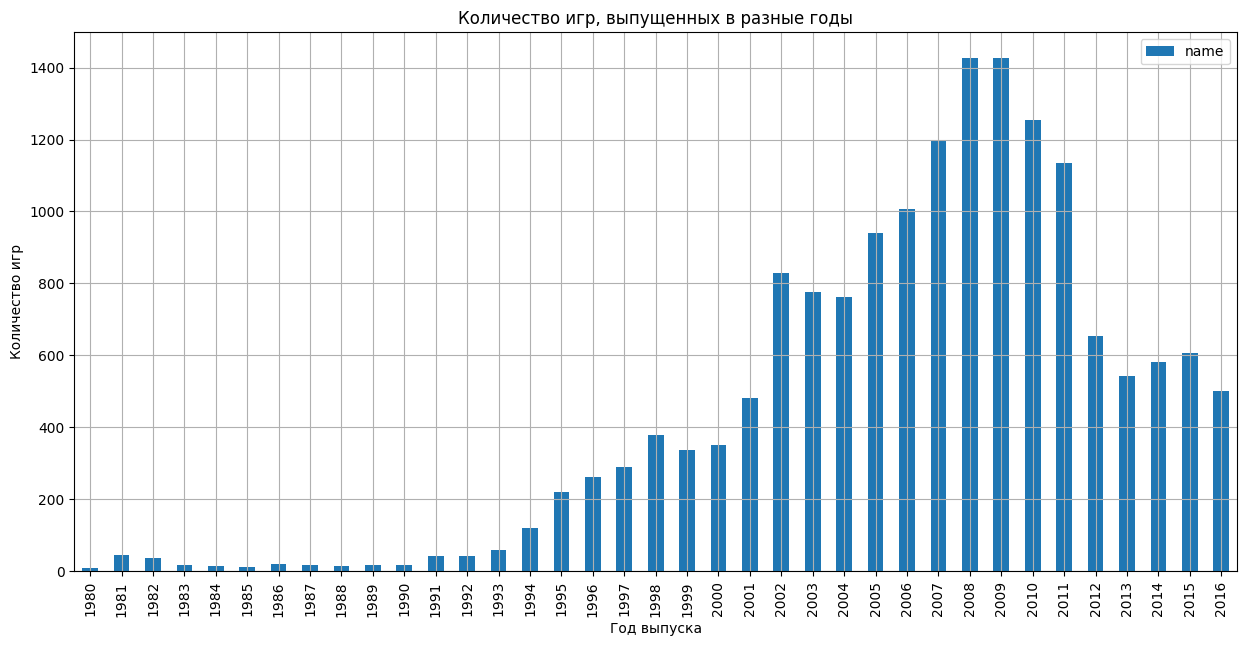

In [14]:
# Создадим сводную таблицу с подсчетом количеситва игр в разные годы и отобразим это на графике

year_release_pivot = df.pivot_table(
    index = 'year_of_release',
    values = 'name',
    aggfunc = 'count'
)
display(year_release_pivot.head())
year_release_pivot.plot(
    kind = 'bar',
    figsize = (15, 7),
    grid = True,
    xlabel = 'Год выпуска',
    ylabel = 'Количество игр',
    title = 'Количество игр, выпущенных в разные годы'
)

**Самое болшьшое количество игр в год выпускалось в период с 2005 - 2011гг.**

### Продажи по платформам

**Предстоит выяснить какие платформы лидируют по продажам, растут или падают? Выделим потенциально прибыльные платформы.**

In [15]:
# Создадим сводную таблицу по топ 10-ти платформам и их общим количеством продаж

top10_pivot = df.pivot_table(
    index = 'platform',
    values = 'total_sales',
    aggfunc = 'sum'
).sort_values('total_sales', ascending=False).head(10)
top10_pivot

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [16]:
# Сгруппируем данные и выясним какое количество общих продаж у платформ по годам

platform_years = df.groupby(['platform', 'year_of_release']).agg({'total_sales': 'sum'})

# Добавим дополнительный столбец с годом выпуска и удалим этот уровень из мультииндекса

platform_years['year'] = platform_years.index
platform_years['year'] = platform_years['year'].apply(lambda row: row[1])

# Избавимся от мультииндекса
platform_years = platform_years.droplevel(1)
platform_years

,total_sales,year
platform,,
2600,11.38,1980
2600,35.68,1981
2600,28.88,1982
2600,5.84,1983
2600,0.27,1984
...,...,...
XB,0.18,2008
XOne,18.96,2013
XOne,54.07,2014


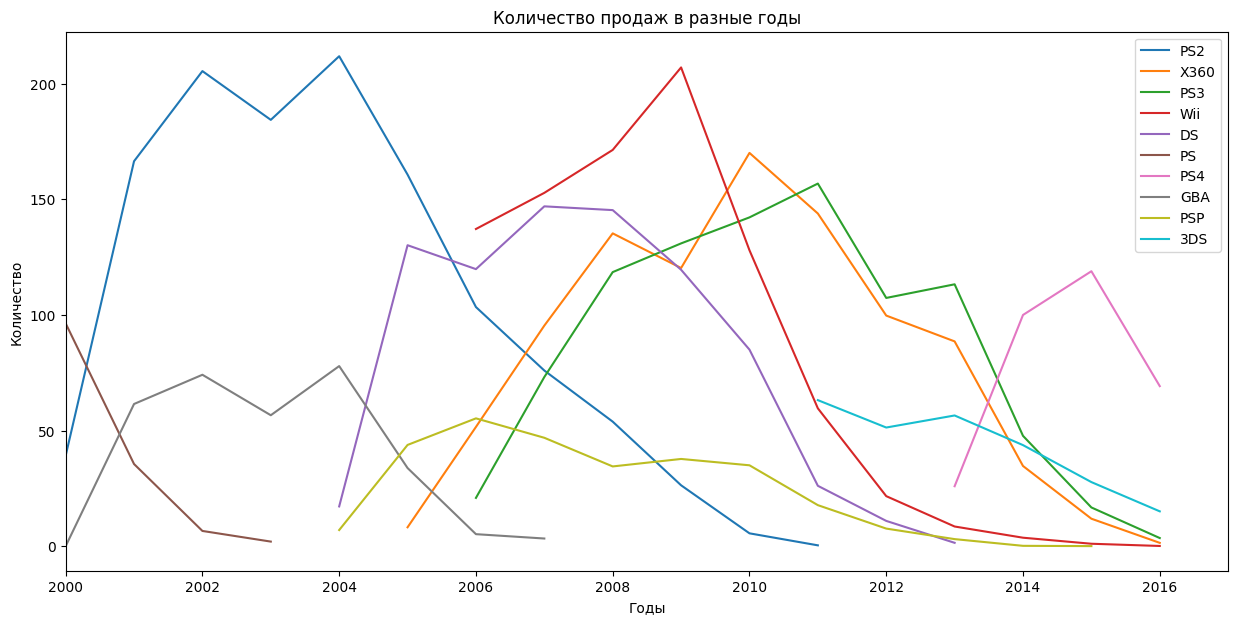

In [17]:
fig, ax = plt.subplots(figsize =(15,7))
for platform in top10_pivot.index:
    platform_years.loc[platform].plot(
        'year', 'total_sales',
        ax=ax,)
ax.legend(top10_pivot.index)
ax.set_title('Количество продаж в разные годы')
ax.set_xlabel('Годы')
ax.set_ylabel('Количество')
ax.set_xlim([2000,2017])
plt.show()

Из графика видно, что с 2004 по 2008 года частота появления платформ 1 новая платформа в год, в 2006 сразу 2 новые платформы.  
Платформы существуют примерно 10 лет.  
За актуальный период возьмем последние 3 года с 2013 по 2016гг.

### Актуальный период для дальнейшего прогноза

In [18]:
# Выделим актуальный период
actual_period = (2013, 2016)

# Выделим данные за актуальный период
actual_df = df.query('@actual_period[0] <= year_of_release <= @actual_period[1]')
actual_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,grand theft auto v,PS3,2013,action,7.02,9.09,0.98,3.96,97.0,8.2,m,21.05
23,grand theft auto v,X360,2013,action,9.66,5.14,0.06,1.41,97.0,8.1,m,16.27
31,call of duty: black ops 3,PS4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,no_ESRB,14.63
33,pokemon x/pokemon y,3DS,2013,role-playing,5.28,4.19,4.35,0.78,NaN,NaN,no_ESRB,14.60
42,grand theft auto v,PS4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,m,12.62


In [19]:
# Выделим самые продаваемые платформы в этом периоде

actual_top10platform = actual_df.groupby(['platform', 'year_of_release']).agg({'total_sales':'sum'})

# Год выпуска вынесем в отдельный столбец
actual_top10platform['year'] = actual_top10platform.index
actual_top10platform['year'] = actual_top10platform['year'].apply(lambda row: row[1])

# Избавимся от мультииндекса
actual_top10platform = actual_top10platform.droplevel(1)

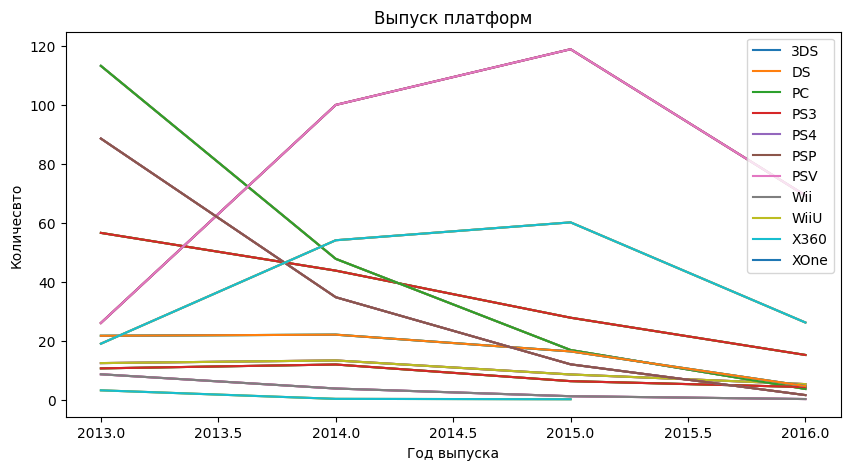

In [20]:
# Поcтроим график для более детального исследования продаж по платформам

fig, ax = plt.subplots(figsize = (10,5))
ax.set_title('Выпуск платформ')

for platform in actual_top10platform.index:
    ax.plot(actual_top10platform.loc[platform]['year'],
        actual_top10platform.loc[platform]['total_sales']
    )
ax.set_xlabel('Год выпуска')
ax.set_ylabel('Количесвто')
ax.legend(actual_top10platform.index.unique())

Из графика видно, что в период с 2013 - 2016 гг. практически у всех платформ спад продаж.  
Исключение составляюс платформы PS4 и 3DS у них с 2013 по 2014 более выраженный рост продаж, с 2014 более плавный рост, а с 2015 - спад продаж.  
Потенциально прибыльными можно выбрать те платформы, спад продаж которых минимален: это PS3, WiiU, DS

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

    
(Построим два boxplot,  без фильтрации выбросов и масштабированный)

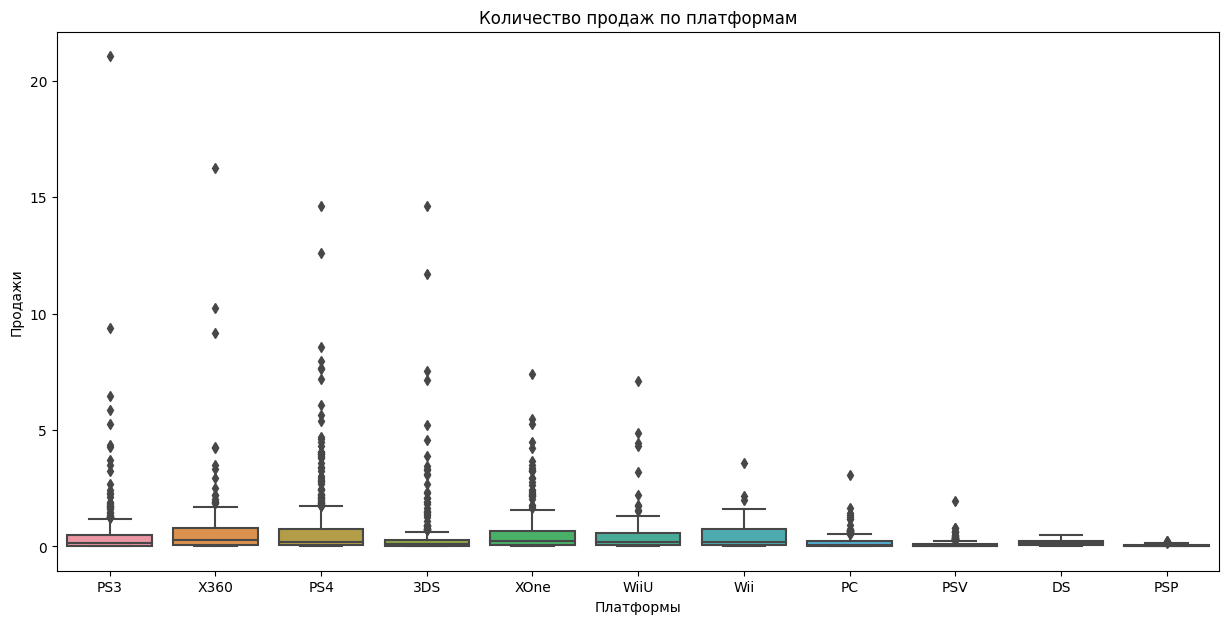

In [21]:
#high_quantile = actual_df['total_sales'].quantile(0.75)
#low_quantile = actual_df['total_sales'].quantile(0.25)
#iqr = high_quantile - low_quantile
#treshold = high_quantile + 1.5*iqr

# Первый график со всеми выбросами

fig, ax = plt.subplots(figsize = (15,7))
sns.boxplot(
    x = 'platform',
    y = 'total_sales',
    data = actual_df,
    ax = ax
)
ax.set_title('Количество продаж по платформам')
ax.set_xlabel('Платформы')
ax.set_ylabel('Продажи')
plt.show()

Большое количество выбросов в значениях продаж у платформ PS3 X360 PS4 и 3DS

Строим второй масштабированный график

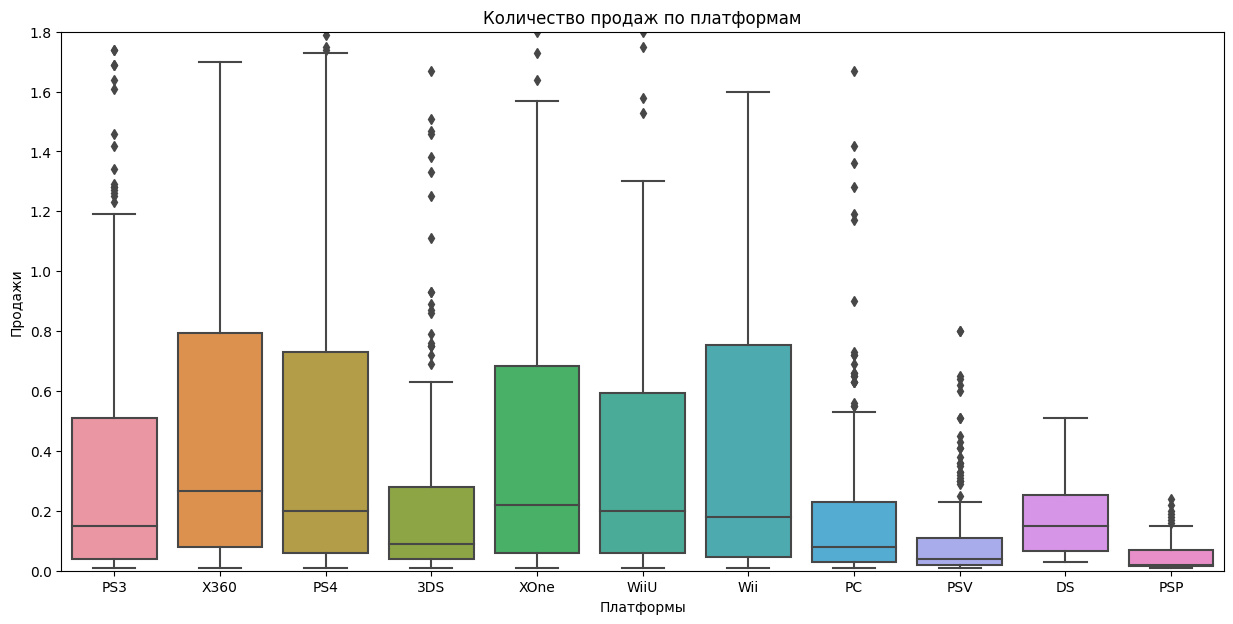

In [22]:
# Второй масштабированный график
fig, ax = plt.subplots(figsize = (15,7))
sns.boxplot(
    x = 'platform',
    y = 'total_sales',
    data = actual_df,
    ax = ax
)
ax.set_title('Количество продаж по платформам')
ax.set_xlabel('Платформы')
ax.set_ylabel('Продажи')
ax.set_ylim(0, 1.8)
plt.show()

Из этого графика видим, что значения распределены более равномерно у платформы DS  
В остальных случаях большая часть значений больше медианы

### Самая популярная платформа

**Далее посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.  Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.**

In [23]:
# Выявим самую продаваемую платформу

popular_platform = actual_df.groupby('platform')['total_sales'].agg('sum')

display(f'Самая продаваемая платформа: {popular_platform[popular_platform == popular_platform.max()].index[0]}')

'Самая продаваемая платформа: PS4'

Платформа ps4 - самая прибыльная, рассмотрим ее более подробно

In [24]:
# Игры в самой популярной платформе

ps4_games = actual_df[actual_df['platform'] == 'PS4']['name']
ps4_games = actual_df.loc[ps4_games.index].reset_index(drop=True)
ps4_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,call of duty: black ops 3,PS4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,no_ESRB,14.63
1,grand theft auto v,PS4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,m,12.62
2,fifa 16,PS4,2015,sports,1.12,6.12,0.06,1.28,82.0,4.3,e,8.58
3,star wars battlefront (2015),PS4,2015,shooter,2.99,3.49,0.22,1.28,NaN,NaN,no_ESRB,7.98
4,call of duty: advanced warfare,PS4,2014,shooter,2.81,3.48,0.14,1.23,83.0,5.7,m,7.66


Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.  
Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

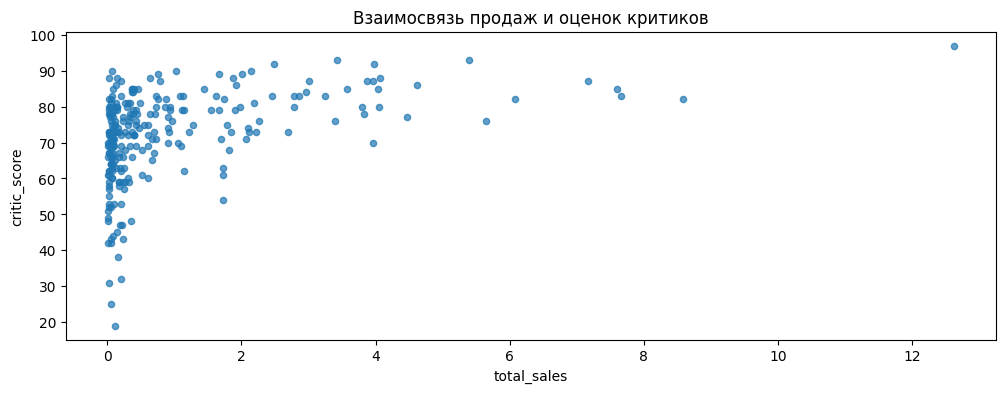

In [25]:
ps4_games.plot(
    kind = 'scatter',
    x = 'total_sales',
    y = 'critic_score',
    alpha = 0.7,
    title = 'Взаимосвязь продаж и оценок критиков',
    figsize = (12,4)
)
plt.show()

In [26]:
'Корреляция продаж и оценок критиков', ps4_games['total_sales'].corr(ps4_games['critic_score'])

('Корреляция продаж и оценок критиков', 0.406567902061781)

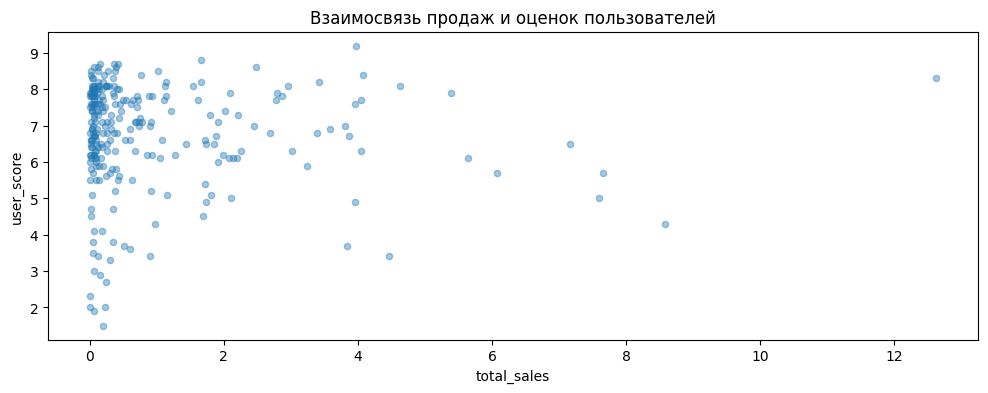

In [27]:
ps4_games.plot(
    kind = 'scatter',
    x = 'total_sales',
    y = 'user_score',
    alpha = 0.4,
    title = 'Взаимосвязь продаж и оценок пользователей',
    figsize = (12,4)
)
plt.show()

In [28]:
'Корреляция продаж и оценок пользователей', ps4_games['total_sales'].corr(ps4_games['user_score'])

('Корреляция продаж и оценок пользователей', -0.031957110204556424)

Взаимосвязь между продажами и оценками пользователей практически отсутствует.  
Более выраженная, взаимосвязь между продажами и оценкой критиков.  
Можно сделать вывод, что количество продаж зависит от оценок экспертов, но не зависит от оценок пользователей.

Проверим как продажи игр на других платформах связаны с оценками критиков и пользователей

In [29]:
other_games = actual_df.query('platform != "PS4"')
print('Корреляция продаж и оценок критиков', other_games['total_sales'].corr(other_games['critic_score']))
print('Корреляция продаж и оценок пользователей', other_games['total_sales'].corr(other_games['user_score']))

Корреляция продаж и оценок критиков 0.2812510848217569
Корреляция продаж и оценок пользователей -0.0011216242093378549


Взаимосвязь продаж игр и оценок критиков на других платформах менее выраженная, чем в играх на платформе PS4,  
А от оценок пользователей продажи также практически не зависят.

Построим диаграммы рассеяния для 5-ти наиболее продаваемых платформ и рассчитаем их корреляции

In [30]:
# Выделим 5 самых продаваемых платформ помиио PS4

popular_platform = popular_platform.sort_values(ascending=False)
popular_platform = popular_platform[popular_platform.index!="PS4"].head()

Корреляция продаж от оценок критиков

PS3 Корреляция 0.3342853393371919

XOne Корреляция 0.4169983280084017

3DS Корреляция 0.3570566142288103

X360 Корреляция 0.3503445460228664

WiiU Корреляция 0.3764149065423912



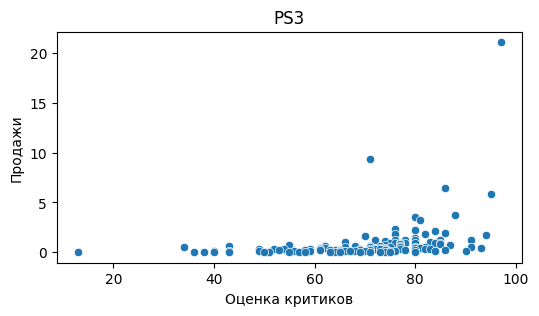

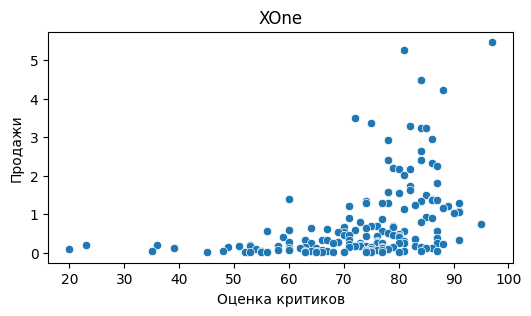

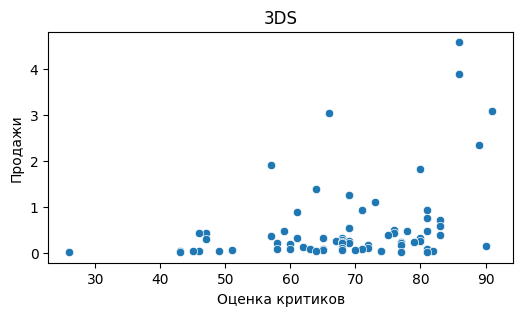

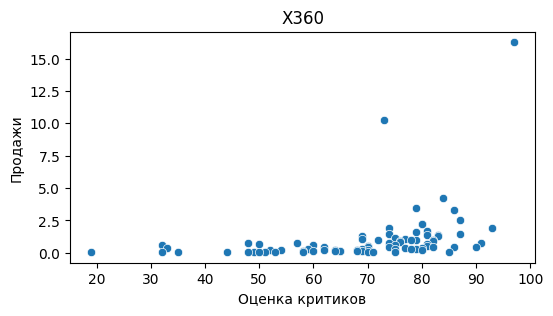

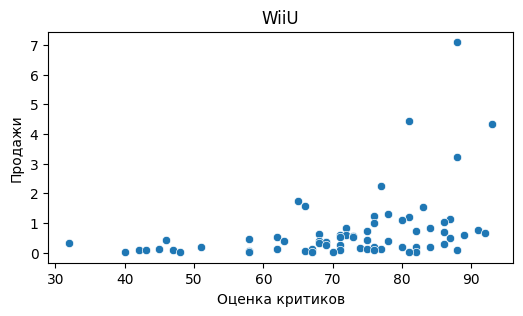

In [31]:
# Постороим диаграммы рассеяния

print('Корреляция продаж от оценок критиков')
print()
for pl in popular_platform.index:
    data = actual_df[actual_df['platform']==pl]
    fig, ax = plt.subplots(figsize = (6,3))
    ax.set_title(pl)
    ax.set_xlabel('Оценка критиков')
    ax.set_ylabel('Продажи')
    sns.scatterplot(
        x = 'critic_score',
        y = 'total_sales',
        data = data
    )
    print(pl, 'Корреляция', data['critic_score'].corr(data['total_sales']))
    print()


Корреляция продаж от оценок критиков не сильно выраженная, но всегда положительная. Самая выраженная взаимосвязь в играх на платформе XOne.  
Общая тенденция в том, что если есть высокая оценка критиков, то это существенно влияет на продажи игр в платформе

Корреляция продаж от оценок пользователей

PS3 Корреляция 0.0023944027357566925
XOne Корреляция -0.06892505328279414
3DS Корреляция 0.24150411773563016
X360 Корреляция -0.011742185147181342
WiiU Корреляция 0.4193304819266187


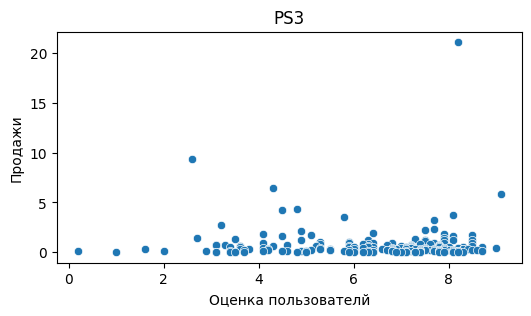

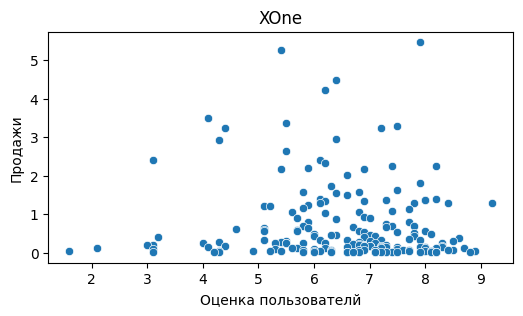

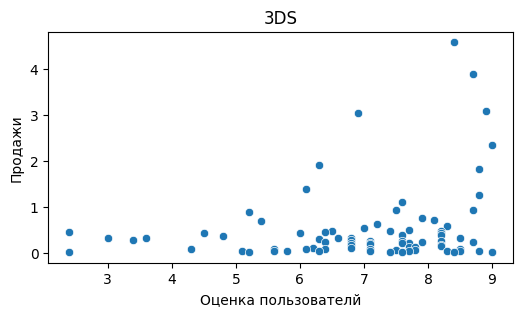

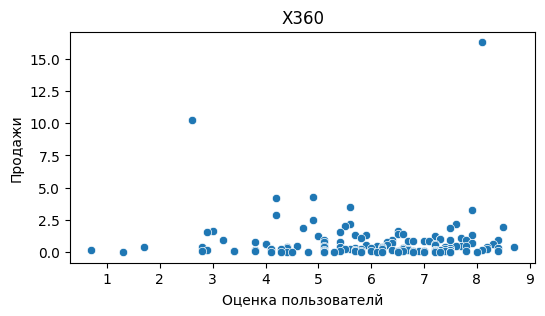

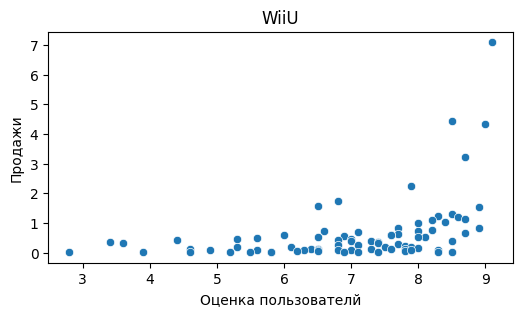

In [32]:
print('Корреляция продаж от оценок пользователей')
print()
for pl in popular_platform.index:
    data = actual_df[actual_df['platform']==pl]
    fig, ax = plt.subplots(figsize = (6, 3))
    ax.set_title(pl)
    ax.set_xlabel('Оценка пользователй')
    ax.set_ylabel('Продажи')
    sns.scatterplot(
        x = 'user_score',
        y = 'total_sales',
        data = data
    )
    print(pl, 'Корреляция', data['user_score'].corr(data['total_sales']))

Взаимосвязь продаж и оценок пользователей менее выражена! незначительная положительная корреляция только в 3DS и более выраженная положительная взаимосвязь в WiiU.  
Общая тенденция в том, что оценики пользователей не сильно влияют на продажи

### Жанры игр

**Посмотрим на самые прибыльные жанры.  
Проверим выделяются ли жанры с высокими и низкими продажами?**

,total_sales
genre,
action,321.87
shooter,232.98
sports,150.65
role-playing,145.89
misc,62.82
platform,42.63
racing,39.89
fighting,35.31
adventure,23.64


<AxesSubplot:title={'center':'Количество продаж по жанрам'}, xlabel='genre'>

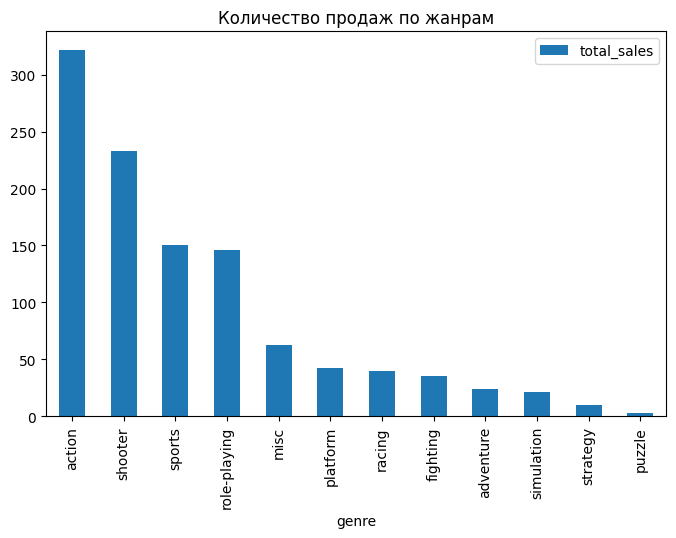

In [33]:
# Сводная таблица продаж по жанрам

genre_pivot = actual_df.pivot_table(
    index = 'genre',
    values = 'total_sales',
    aggfunc = 'sum'
).sort_values(by='total_sales', ascending=False)
display(genre_pivot)
genre_pivot.plot(
    kind='bar',
    figsize = (8,5),
    title = 'Количество продаж по жанрам'
)

In [34]:
# Максимальные и минимальные продажи по жанрам

print('Самый прибыльный жанр:', genre_pivot.query('total_sales == total_sales.max()').index[0])
print('5 самых прибыльных жанров:', genre_pivot.head(5).index)
print('Наименее прибыльный жанр:', genre_pivot[genre_pivot['total_sales'] == genre_pivot['total_sales'].min()].index[0])

Самый прибыльный жанр: action
5 самых прибыльных жанров: Index(['action', 'shooter', 'sports', 'role-playing', 'misc'], dtype='object', name='genre')
Наименее прибыльный жанр: puzzle


Из этой сводной таблицы очевидно, что выделяются жанры с высокими и низкими продажами?  
Самыми прибыльными жанрами являются 'action', 'shooter', 'sports', 'role-playing', 'misc'. При чем 'action' с большим отрывом лидирует по продажам!  

Меньше всего продаж у жанра 'puzzle'

Построим графики сравнения медианных значений продаж по жанрам

Действительно, при сравнении медианных значений, для более несмещенной от платформ оценки, оказывается, что наиболее популярные жанры не связаны с наиболее популярными платформами. Здесь более корректно анализировать медианные значения продаж по жанрам, они отличаются от показателей тех жанров, где максимальные продажи. Так например большое количество продаж в жанре action - скорее выбивающиеся значения (которые могут быть обусловлены успешностью какой то одной игры).

              total_sales
genre                    
shooter             0.450
sports              0.240
platform            0.225
role-playing        0.125
fighting            0.125
racing              0.120
action              0.110
simulation          0.100
misc                0.100
strategy            0.080
puzzle              0.060
adventure           0.030


<AxesSubplot:title={'center':'Медианные продажи по жанрам'}, xlabel='Жанр', ylabel='Медиана продаж'>

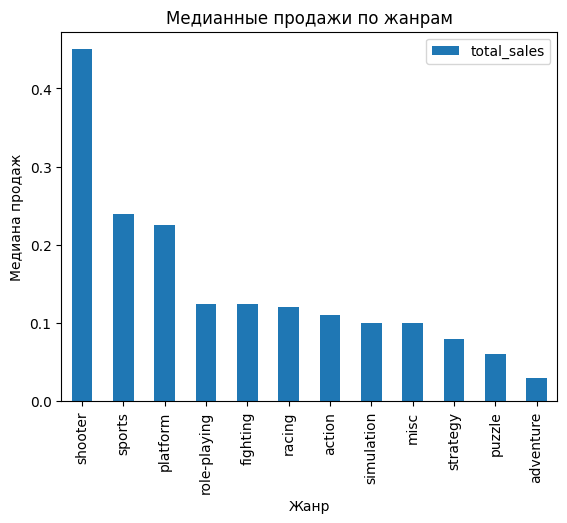

In [35]:
genre_sales = actual_df.pivot_table(
    index = 'genre',
    values = 'total_sales',
    aggfunc = 'median'
).sort_values(by='total_sales', ascending=False)
print(genre_sales)
genre_sales.plot(
    kind = 'bar',
    title = 'Медианные продажи по жанрам',
    xlabel = 'Жанр',
    ylabel = 'Медиана продаж'
)


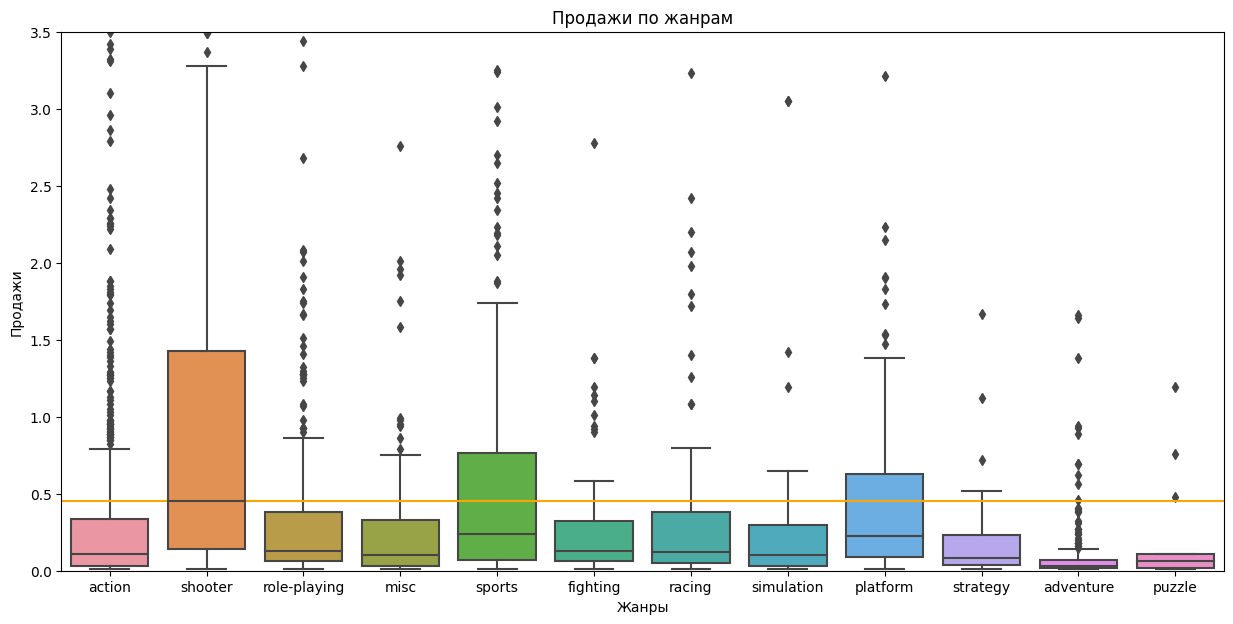

In [36]:
# Построим диаграммы размаха

fig, ax = plt.subplots(figsize = (15,7))

sns.boxplot(
    x = 'genre',
    y = 'total_sales',
    data = actual_df,
    ax = ax
)
ax.set_title('Продажи по жанрам')
ax.set_xlabel('Жанры')
ax.set_ylabel('Продажи')
ax.set_ylim(0, 3.5)
plt.axhline(genre_sales['total_sales'].max(), c='orange')

In [37]:
print('Самыe популярные жанры:', genre_sales.index[0:5].values)

Самыe популярные жанры: ['shooter' 'sports' 'platform' 'role-playing' 'fighting']


    
Самые продаваемые жанры 'shooter' - с большим отрывом, 'sports', 'platform', 'role-playing', 'fighting'.  
    
Менее популярный жанр - 'adventure'    

---

## Портрет пользователя каждого региона

<div style="border:solid gray 2px; padding: 20px">
    
**Задание**  
    Определить для пользователя каждого региона следующие позиции (NA, EU, JP):  
    
- Самые популярные платформы (топ-5). Опишем различия в долях продаж.  
- Самые популярные жанры (топ-5). Поясним разницу.  
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

### Топ-5 Платформ

In [38]:
 # Создадим сводную таблицу по регионам и количеству продаж разных платформ

region_platform_pivot = actual_df.pivot_table(
    index = 'platform',
    values = ['na_sales', 'eu_sales', 'jp_sales'],
    aggfunc = 'sum'
)
region_platform_pivot

,eu_sales,jp_sales,na_sales
platform,,,
3DS,30.96,67.81,38.20
DS,0.85,0.00,0.57
PC,25.36,0.00,11.11
PS3,67.81,23.35,63.50
PS4,141.09,15.96,108.74
PSP,0.17,3.29,0.00
PSV,6.10,18.59,5.04
Wii,5.93,0.05,6.56
WiiU,19.85,10.88,29.21


In [39]:
# Нужно отсортировать значения и получить список самых продаваемых платформ

eu_top5_platform = region_platform_pivot.sort_values(by='eu_sales', ascending=False)
jp_top5_platform = region_platform_pivot.sort_values(by='jp_sales', ascending=False)
na_top5_platform = region_platform_pivot.sort_values(by='na_sales', ascending=False)

list_top_platform = [eu_top5_platform.index[:5], jp_top5_platform.index[:5], na_top5_platform.index[:5]]

In [40]:
# Рассчитаем доли продаж по платформам по каждому региону

for index, top in enumerate (list_top_platform):
    print()
    if index == 0:
        print('Продажи в Европе')
    elif index == 1:
        print('Продажи в Японии')
    elif index == 2:
        print('Продажи в Северной Америке')
    print('топ5 платформ:', top.values)
    print()

    for platform in top:
        data = region_platform_pivot.loc[platform, ['eu_sales', 'jp_sales', 'na_sales']]
        if index == 0:
            sales = data['eu_sales']
        elif index == 1:
            sales = data['jp_sales']
        elif index == 2:
            sales = data['na_sales']
        ratio = sales/ sum(data)
        print('Платформа:', platform)
        print('Доля продаж', ratio)
        print()


Продажи в Европе
топ5 платформ: ['PS4' 'PS3' 'XOne' 'X360' '3DS']

Платформа: PS4
Доля продаж 0.5308326122126491

Платформа: PS3
Доля продаж 0.438445622656149

Платформа: XOne
Доля продаж 0.3556704584625991

Платформа: X360
Доля продаж 0.3410056941214212

Платформа: 3DS
Доля продаж 0.22603489815288016


Продажи в Японии
топ5 платформ: ['3DS' 'PS3' 'PSV' 'PS4' 'WiiU']

Платформа: 3DS
Доля продаж 0.4950719135577133

Платформа: PS3
Доля продаж 0.15097633518686152

Платформа: PSV
Доля продаж 0.6252943155062227

Платформа: PS4
Доля продаж 0.060047405846721094

Платформа: WiiU
Доля продаж 0.18151484818151484


Продажи в Северной Америке
топ5 платформ: ['PS4' 'XOne' 'X360' 'PS3' '3DS']

Платформа: PS4
Доля продаж 0.40911998194062976

Платформа: XOne
Доля продаж 0.6419855222337125

Платформа: X360
Доля продаж 0.6549041623225599

Платформа: PS3
Доля продаж 0.4105780421569895

Платформа: 3DS
Доля продаж 0.2788931882894064



Можно сделать вывод: В каждом регионе разные предпочтения по платформам!

В Европе самая продаваемая - PS4  
В Японии - PSV  
В Северной Америке - X360 и XOne  

### Топ-5 Жанры

In [41]:
# Создадим сводную таблицу поп жанрам в разных регионах

region_genre_pivot = actual_df.pivot_table(
    index = 'genre',
    values = ['eu_sales', 'jp_sales', 'na_sales'],
    aggfunc = 'median'
)

In [42]:
eu_top5_genre = region_genre_pivot.sort_values(by='eu_sales', ascending=False)
jp_top5_genre = region_genre_pivot.sort_values(by='jp_sales', ascending=False)
na_top5_genre = region_genre_pivot.sort_values(by='na_sales', ascending=False)

list_top_genre = [eu_top5_genre.index[:5], jp_top5_genre.index[:5], na_top5_genre.index[:5]]
list_top_genre

[Index(['shooter', 'platform', 'racing', 'sports', 'simulation'], dtype='object', name='genre'),
 Index(['role-playing', 'fighting', 'misc', 'puzzle', 'action'], dtype='object', name='genre'),
 Index(['shooter', 'platform', 'sports', 'fighting', 'racing'], dtype='object', name='genre')]

In [43]:
# Посчитаем самые продаваемые жанры в разных регионах

for index, top in enumerate(list_top_genre):
    print()
    if index == 0:
        print('Продажи в Европе')
    elif index == 1:
        print('Продажи в Японии')
    elif index == 2:
        print('Продажи в Северной Америке')
    print('топ5 жанров:', top.values)
    print()
    for genre in top:
        data = region_genre_pivot.loc[genre, ['eu_sales', 'jp_sales', 'na_sales']]
        if index == 0:
            sales = data['eu_sales']
            
        elif index == 1:
            sales = data['jp_sales']
        elif index == 2:
            sales = data['na_sales']
        ratio = sales/sum(data)
        print('Жанр', genre)
        print('Доля продаж', ratio)
        print()
    print()


Продажи в Европе
топ5 жанров: ['shooter' 'platform' 'racing' 'sports' 'simulation']

Жанр shooter
Доля продаж 0.48717948717948717

Жанр platform
Доля продаж 0.4705882352941177

Жанр racing
Доля продаж 0.6666666666666666

Жанр sports
Доля продаж 0.38461538461538464

Жанр simulation
Доля продаж 1.0



Продажи в Японии
топ5 жанров: ['role-playing' 'fighting' 'misc' 'puzzle' 'action']

Жанр role-playing
Доля продаж 0.625

Жанр fighting
Доля продаж 0.3157894736842105

Жанр misc
Доля продаж 0.5

Жанр puzzle
Доля продаж 1.0

Жанр action
Доля продаж 0.19999999999999998



Продажи в Северной Америке
топ5 жанров: ['shooter' 'platform' 'sports' 'fighting' 'racing']

Жанр shooter
Доля продаж 0.5128205128205129

Жанр platform
Доля продаж 0.5294117647058824

Жанр sports
Доля продаж 0.6153846153846154

Жанр fighting
Доля продаж 0.47368421052631576

Жанр racing
Доля продаж 0.3333333333333333




В Европе самый продаваемый жанр - racing  
В Японии - role-playing  
В Северной Америке - shooter  

Большая часть продаж охватывает Европу и Северную Америку, гораздо меньше продаж в Японии.

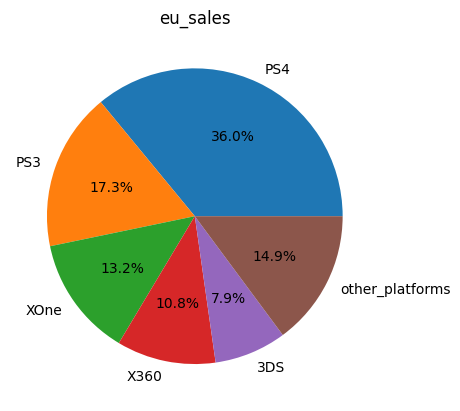

eu_sales
PS4                141.09
PS3                 67.81
XOne                51.59
X360                42.52
3DS                 30.96
other_platforms     58.26
dtype: float64




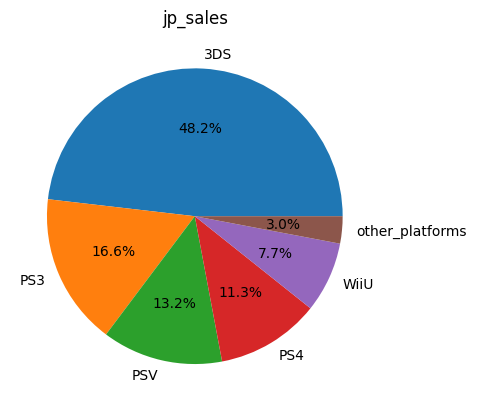

jp_sales
3DS                67.81
PS3                23.35
PSV                18.59
PS4                15.96
WiiU               10.88
other_platforms     4.19
dtype: float64




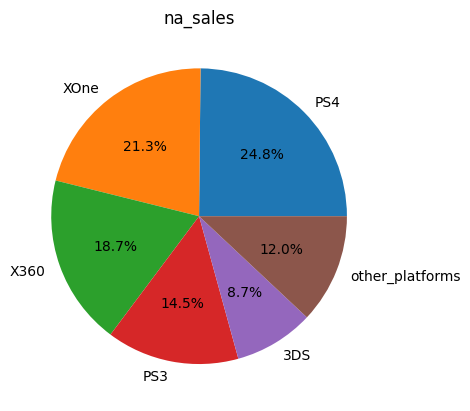

na_sales
PS4                108.74
XOne                93.12
X360                81.66
PS3                 63.50
3DS                 38.20
other_platforms     52.49
dtype: float64



In [44]:
# Покажем топ 5 платформ в разных регионах

list_plat = [eu_top5_platform[:5], jp_top5_platform[:5], na_top5_platform[:5]]
platform_other = [eu_top5_platform[5:].sum()[0], jp_top5_platform[5:].sum()[1], na_top5_platform[5:].sum()[2]]

for num, plat in enumerate(list_plat):
    if num == 0:
        plat = plat['eu_sales']
    elif num == 1:
        plat = plat['jp_sales']
    else:
        plat = plat['na_sales']
    plat = pd.concat([plat, pd.Series({'other_platforms':platform_other[num]})])
    print()
    
# Построим графики 
    plat.plot(
    kind = 'pie',
    y = num,
    autopct='%1.1f%%',
    legend = False,
    ylabel='',
    title = list_plat[num].columns[num]
    )
    plt.show()
    print(list_plat[num].columns[num])
    print(plat)
    print()


In [45]:
# График и данные отражают медианные значения продаж по жанрам в разных регионах

list_genr = [eu_top5_genre[:5], jp_top5_genre[:5], na_top5_genre[:5]]
other_genre = [eu_top5_genre[5:].sum()[0], jp_top5_genre[5:].sum()[1], na_top5_genre[5:].sum()[2]]

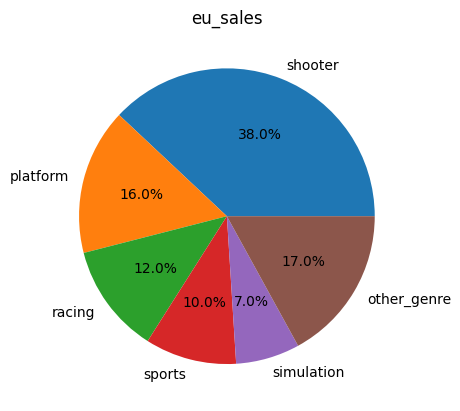

shooter        0.190
platform       0.080
racing         0.060
sports         0.050
simulation     0.035
other_genre    0.085
dtype: float64



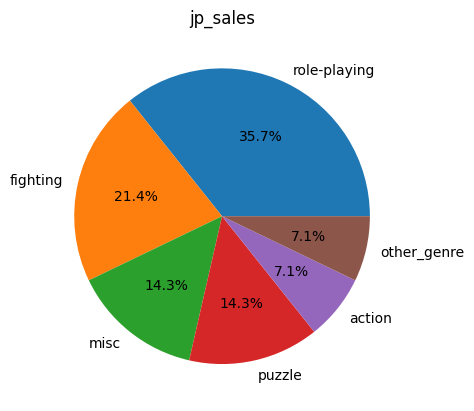

role-playing    0.05
fighting        0.03
misc            0.02
puzzle          0.02
action          0.01
other_genre     0.01
dtype: float64



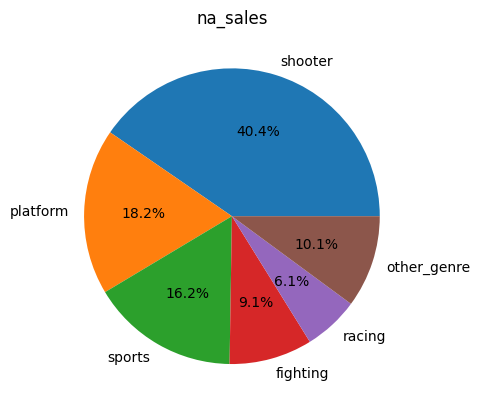

shooter        0.200
platform       0.090
sports         0.080
fighting       0.045
racing         0.030
other_genre    0.050
dtype: float64



In [46]:
for num, genre in enumerate(list_genr):
    if num == 0:
        genre = genre['eu_sales']
    elif num == 1:
        genre = genre['jp_sales']
    else:
        genre = genre['na_sales']
    genre = pd.concat([genre, pd.Series({'other_genre':other_genre[num]})])
    genre.plot(
    kind = 'pie',
    y = num,
    autopct='%1.1f%%',
    legend = False,
    title = list_genr[num].columns[num],
    ylabel=''
    )
    plt.show()
    print(genre)
    print()

Самый популярный жанр:  
    В Европе - shooter  
    В Японии - role-playing  
    В Северной Америке - shooter

### Рейтинг ESRB

**Значения ESRB**

**e** - («Everyone») — «Для всех»  
**e10+** - («Everyone 10 and older») — «Для всех от 10 лет и старше»  
**m** - («Mature») — «Для взрослых»  
**t** - («Teen») — «Подросткам»  
**rp** - («Rating Pending») — «Рейтинг ожидается»

In [47]:
region_esrb_pivot = actual_df.pivot_table(
    index = 'rating',
    values = ['eu_sales', 'jp_sales', 'na_sales'],
    aggfunc = 'sum'
)
region_esrb_pivot

,eu_sales,jp_sales,na_sales
rating,,,
e,83.36,15.14,79.05
e10+,42.69,5.89,54.24
m,145.32,14.11,165.21
no_ESRB,78.91,85.05,89.42
t,41.95,20.59,49.79


Из этой сводной таблицы очевидно, что рейтинг влияет на продажи в отдельных регионах:  

Так например, в Европе и Северной Америке большинство продаж с большим отрывом приходится на игры с рейтингом m - для взрослых.  

В Японии - большинство продаваемых игр ожидают рейтинг. Из тех игр, у которых рейтинг присвоен, самые продаваемые с рейтингом t - для подростков

### Вывод о пользовательском портрете

**Самые продаваемые платформы жанры и рейтинг для разных регионов**

In [48]:
# Пользовательский портрет

index = ['Европа', 'Япония', 'Сев. Америка']
data = [
    ['PS4', 'shooter', 'M'],
    ['PSV', 'role-playing', 'T'],
    ['PS4 XOne', 'shooter', 'M']
]
columns = ['Платформа', 'Жанр', 'Рейтинг']
user_portrait = pd.DataFrame(index = index, data=data, columns=columns)
user_portrait

,Платформа,Жанр,Рейтинг
Европа,PS4,shooter,M
Япония,PSV,role-playing,T
Сев. Америка,PS4 XOne,shooter,M


---

## Проверка гипотез

<div style="border:solid gray 2px; padding: 20px">

По заданию проекта нужно проверить:  
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.    
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен- игры) и
Sports (англ. «спортивные соревнования») разные.  

Зададим самостоятельно пороговое значение alpha и поясним:
Как сформулировали нулевую и альтернативную гипотезы;
Какой критерий применили для проверки гипотез и почему.


### Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

- Нулевая гипотеза: Средние значения пользовательских оценок платформ  XOne и PC равны  
- Альтернативная гипотеза: Средние значения пользовательских оценок платформ  XOne и PC разные  
Понадобится метод ttest_ind()

In [49]:
# Статистический тест на равенство средних двух выборок

XOne_score = actual_df.query('platform == "XOne"')['user_score'].dropna()
PC_score = actual_df.query('platform == "PC"')['user_score'].dropna()

print('Дисперсия XOne_score', np.var(XOne_score, ddof=1))
print('Дисперсия PC_score', np.var(PC_score, ddof=1))

# ст.тест для выборок если их дисперсии не равны

alpha = .05
result = st.ttest_ind(XOne_score, PC_score, equal_var=False)
print('Значение p-value', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

Дисперсия XOne_score 1.9069968429360695
Дисперсия PC_score 3.035892752408882
Значение p-value 0.14759594013430463
Не удалось отвергнуть нулевую гипотезу



Добавим Графики для наглядности и непротиворечивости гипотез

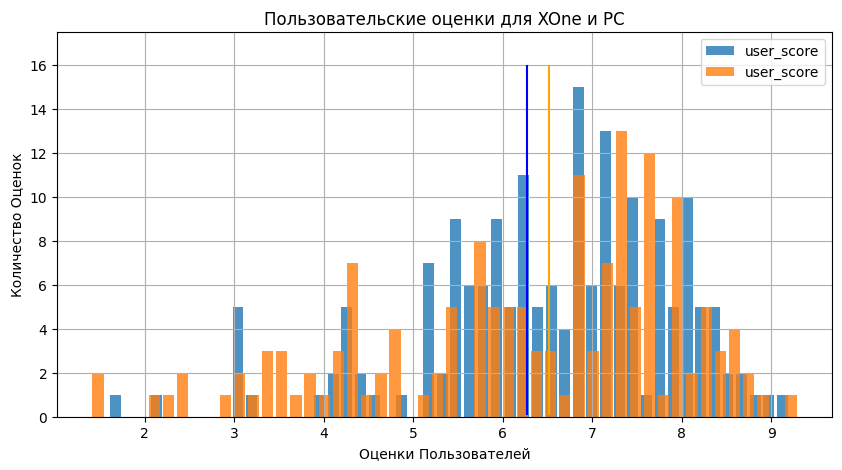

Среднее в XOne_score: 6.521428571428572
Среднее в PC_score: 6.2696774193548395


In [50]:
fig,ax = plt.subplots(figsize=(10,5))
XOne_score.plot(
    kind = 'hist',
    bins=50,
    linewidth =0.9,
    ylim = (0,17.5),
    xlabel = 'Оценки пользователей',
    #ax.set_ylabel('Количество оценок'),
    grid=True,
    rwidth=0.8,
    alpha = 0.8,
    legend=True
    )
PC_score.plot(
    kind = 'hist',
    bins=50,
    linewidth =0.9,
    grid=True,
    rwidth=0.8,
    alpha = 0.8,
    legend=True,
    )

ax.set_title('Пользовательские оценки для XOne и PC')
ax.set_xlabel('Оценки Пользователей')
ax.set_ylabel('Количество Оценок')
ax.vlines(XOne_score.mean(),16, 0.1, color='orange')
ax.vlines(PC_score.mean(),16, 0.1, color='blue')
#sns.lineplot()
plt.show()
print('Среднее в XOne_score:', XOne_score.mean())
print('Среднее в PC_score:', PC_score.mean())

По результатм теста - не удалось отвергнуть нулевую гипотезу! Можно сделать вывод, что вероятнее всего средние двух выборок (средние пользовательские оценки для двух платформ) равны

### Гипотеза 2. Средние пользовательские рейтинги жанров Action и Sports разные.

- Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports равны.  
- Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные.  
Будем применять ttest для двух выборок

In [51]:
# Статистический тест на равенство средних двух выборок (Пропуски удалим)

action_score = actual_df.query('genre == "action"')['user_score'].dropna()
sports_score = actual_df.query('genre == "sports"')['user_score'].dropna()

print('Дисперсия action_score:', np.var(action_score, ddof=1))
print('Дисперсия sports_score:', np.var(sports_score, ddof=1))

alpha = .05
result = st.ttest_ind(action_score, sports_score, equal_var=False)
print('Значение p-value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

Дисперсия action_score: 1.7693609042482705
Дисперсия sports_score: 3.180612814465409
Значение p-value: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


По результатам теста - отвергаем нулевую гипотезу. Можно сделать вывод, что с большой долей вероятности средние выборок пользовательских оценок игр в двух жанрах - разные

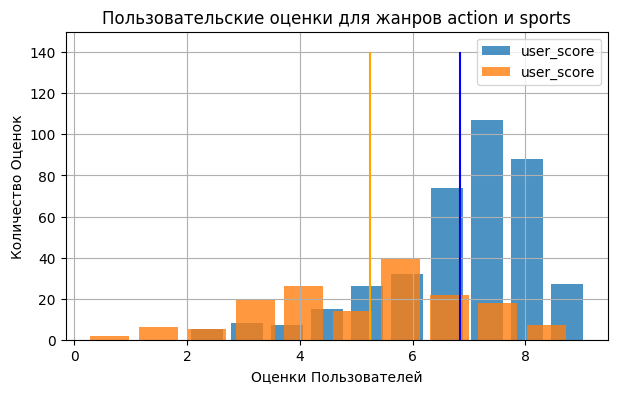

Среднее в выборке action_score: 6.837532133676092
Среднее в выборке sports_score: 5.238124999999999


In [52]:
fig,ax = plt.subplots(figsize=(7,4))
action_score.plot(
    kind = 'hist',
    linewidth =0.9,
    rwidth = 0.8,
    ylim = (0,150),
    #ax.set_ylabel('Количество оценок'),
    grid=True,
    alpha = 0.8,
    legend='action_score'
    )
sports_score.plot(
    kind = 'hist',
    linewidth =0.9,
    rwidth = 0.8,
    grid=True,
    alpha = 0.8,
    legend='sports_score'
    )

ax.set_title('Пользовательские оценки для жанров action и sports')
ax.set_xlabel('Оценки Пользователей')
ax.set_ylabel('Количество Оценок')
ax.vlines(action_score.mean(),140, 0.1, color='blue')
ax.vlines(sports_score.mean(),140, 0.1, color='orange')

plt.show()
print('Среднее в выборке action_score:', action_score.mean())
print('Среднее в выборке sports_score:', sports_score.mean())


---

## Общий вывод

<div style="border:solid gray 2px; padding: 20px">
    
В этом проекте было необходимо выявить определяющие успешность игры закономерности.  
    
Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  
    
В этом проекте было выявлено как влияют на продажи регион пользователя, платформа, на которой была выпущена игра и жанр игры.  
    
**Самая продаваемая платформа** -  PS4.  
**Самые популярные жанры** - 'shooter', 'sports', 'platform', 'role-playing', 'fighting'.  
    
При планировании рекламного бюджета важно учитывать, что предпочтения зависят от региона.  
Так например:  
- **В Европе** самая продаваемая платформа - PS4, жанр shooter  
- **В Японии** - платформа 3DS, жанр role-playing  
- **В Северной Америке** -  платформы PS4 и XOne, жанр shooter  
    
При проверке гипотез можно сделать вывод, что c большой вероятностью средние выборок (пользовательские оценки для платформ XboxOne и PC) равны.  
Также с большой вероятностью можно предположить, что средние выборок пользовательских оценок игр в жанрах action и sports - разные